## Experiment: Confirming in-context learning behaviors in BERT
We want to show that BERT demonstrates in-context learning (ICL), which has been observed in unidirectional models

In [1]:
from imports import *
utils.logging.set_verbosity_error()

/n/helmod/apps/centos7/Core/Anaconda3/2021.05-jupyterood-fasrc01/x/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
from transformers import BertForMaskedLM
from datasets import load_dataset

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained("bert-base-uncased", output_attentions=True)

In [4]:
model_masked = BertForMaskedLM.from_pretrained('bert-base-uncased')

### Load Wiki dataset of article text

In [5]:
# !pip3 install apache_beam mwparserfromhell

In [6]:
# obtained fromnum_examples://huggingface.co/datasets/wikipedia
dataset = load_dataset("wikipedia", "20220301.simple")
dataset_text = dataset['train']['text']

Found cached dataset wikipedia (/n/home01/cynthiachen/.cache/huggingface/datasets/wikipedia/20220301.simple/2.0.0/aa542ed919df55cc5d3347f42dd4521d05ca68751f50dbc32bae2a7f1e167559)


  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
import random
num_examples = 50

# choose random examples

loss_50 = []
loss_500 = []
for i in range(num_examples):
    # ensure input example has at least 500 tokens
    num_tokens = 0
    while num_tokens < 500:
        example_ind = random.randint(0, len(dataset_text))
        inputs = tokenizer(dataset_text[example_ind], return_tensors='pt')
        num_tokens = len(inputs.input_ids[0])

    inputs['labels'] = inputs.input_ids.detach().clone()

    # calculate single-token loss with 500 tokens in context
    cut_length = min(500, num_tokens)
    for k in inputs.keys():
        inputs[k] = inputs[k][:, 0:cut_length]
    selection = [random.randint(0, 499)]
    orig_token = inputs.input_ids[0, selection]
    inputs.input_ids[0, selection] = 103
    outputs = model_masked(**inputs)
    loss_500.append(outputs.loss)
    inputs.input_ids[0, selection] = orig_token
   
    # calculate loss with 50 tokens in context
    cut_length = 50
    for k in inputs.keys():
        inputs[k] = inputs[k][:, 0:cut_length]
    selection = [random.randint(0, 49)]
    inputs.input_ids[0, selection] = 103
    outputs = model_masked(**inputs)
    loss_50.append(outputs.loss)

### ICL metric: Loss(500th token) - Loss (50th token)

In [8]:
diff = []
for i in range(num_examples):
    diff.append(float(loss_50[i]) - float(loss_500[i]))
diff = np.array(diff)

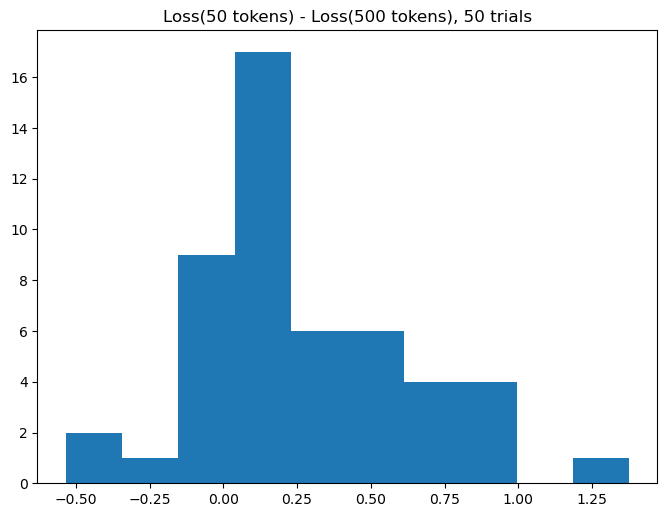

In [15]:
fig, ax = plt.subplots(figsize=(8, 6), dpi = 100)
plt.hist(diff)
plt.title('Loss(50 tokens) - Loss(500 tokens), 50 trials')
plt.savefig('figs/icl.png', dpi = 150)

In [9]:
diff.mean()

0.25550899416208267